# 0) Extracción de los datos

Extraemos los datos de Red Eléctrica haciendo consultas a la API de e-sios.

Para ello, tenemos que solicitar un token y hacer llamadas a la API a través de la siguiente URL:

In [1]:
token = 'cb25867a53d723d058c6d15d29d416fc981bfe92d68e1709ae61ae0157806312'
token

'cb25867a53d723d058c6d15d29d416fc981bfe92d68e1709ae61ae0157806312'

In [2]:
# url para llamar a la API de E-SIOS
url = 'https://api.esios.ree.es/indicators'

Importamos los siguientes paquetes y librerías para realizar las consultas:

In [1]:
# paquetes para importar
import requests
import json
import numpy as np
import datetime
import string
import pandas as pd

## 0.1) Elementos que ofrece la API

La información que se puede obtener de la API de e-sios se puede obtener y resumir de la siguiente manera:

In [4]:
resp_elementos = requests.get(
    url, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Content-Type':'application/json',
        'Authorization':'Token token="%s"' % (token)
    }
)

In [5]:
elements_resume = []

for element in resp_elementos.json()['indicators']:
    local_result = {}
    local_result['id'] = element['id']
    local_result['name'] = element['name']
    
    elements_resume.append(local_result)

In [6]:
elements_resume

[{'id': 10393, 'name': 'Desglose peaje 2.0TD Término de energía'},
 {'id': 10391,
  'name': 'Término de facturación de energía activa del PVPC 2.0TD suma componentes'},
 {'id': 1879,
  'name': 'Desglose peaje por defecto 2.0TD Excedente o déficit subastas renovables'},
 {'id': 1878,
  'name': 'Desglose peaje por defecto 2.0TD Coste de comercialización'},
 {'id': 1001,
  'name': 'Término de facturación de energía activa del PVPC 2.0TD'},
 {'id': 1877, 'name': 'Desglose peaje por defecto 2.0TD Financiación OS'},
 {'id': 1876, 'name': 'Desglose peaje por defecto 2.0TD Peajes y cargos'},
 {'id': 1875,
  'name': 'Desglose peaje por defecto 2.0TD Mercado diario e intradiario'},
 {'id': 1874, 'name': 'Desglose peaje por defecto 2.0TD Financiación OM'},
 {'id': 1873,
  'name': 'Desglose peaje por defecto 2.0TD Servicio de interrumpibilidad'},
 {'id': 1872, 'name': 'Desglose peaje por defecto 2.0TD Pago por capacidad'},
 {'id': 1871, 'name': 'Desglose peaje por defecto 2.0TD Servicios de ajuste

## 0.2) Preparación de los datos

Después de hacer consultas a la API para obtener los datos de los precios de la energía que necesitamos vemos las siguientes limitaciones:

* Los datos más antiguos que podemos extraer son de la fecha 01/04/2014.
* A partir del 01/06/2021 el formato de los datos es diferente, por lo tanto, tenemos que tener en cuenta esto a la hora de hacer la transformación previa para preparar el dataset.

### a) Datos antiguos (entre el 01/04/2014 y el 01/06/2021):

Los datos tienen el siguiente formato:

In [7]:
# start_date='01-01-2014T00:00:00 00:00'
# end_date='01-06-2021T00:00:00 00:00'
# date_type='datos'

start_date='01-04-2014T00:00:00 00:00'
end_date='01-06-2021T00:00:00 00:00'
date_type='datos'

url_resumen = 'https://api.esios.ree.es/indicators/10229/?start_date='+start_date+'&end_date='+end_date
resp_resumen_historico = requests.get(
    url_resumen, 
    headers = {
        'Accept': 'application/json; application/vnd.esios-api-v1+json',
        'Host' : 'api.esios.ree.es',
        'Content-Type':'application/json',
        'Authorization':'Token token="%s"' % (token),
        'Cookie': ''
    }
)

resp_resumen_historico.json()

{'indicator': {'name': 'Término de facturación de energía activa del PVPC peaje por defecto suma componentes',
  'short_name': 'PVPC T. Defecto',
  'id': 10229,
  'composited': True,
  'step_type': 'linear',
  'disaggregated': False,
  'magnitud': [{'name': 'Precio', 'id': 23}],
  'tiempo': [{'name': 'Hora', 'id': 4}],
  'geos': [{'geo_id': 3, 'geo_name': 'España'}],
  'values_updated_at': '2021-05-30T20:20:22.000+02:00',
  'values': [{'value': 92.75,
    'datetime': '2014-04-01T00:00:00.000+02:00',
    'datetime_utc': '2014-03-31T22:00:00Z',
    'tz_time': '2014-03-31T22:00:00.000Z',
    'geo_id': 3,
    'geo_name': 'España'},
   {'value': 86.46,
    'datetime': '2014-04-01T01:00:00.000+02:00',
    'datetime_utc': '2014-03-31T23:00:00Z',
    'tz_time': '2014-03-31T23:00:00.000Z',
    'geo_id': 3,
    'geo_name': 'España'},
   {'value': 78.82,
    'datetime': '2014-04-01T02:00:00.000+02:00',
    'datetime_utc': '2014-04-01T00:00:00Z',
    'tz_time': '2014-04-01T00:00:00.000Z',
    'geo

Nos interesan los datos dentro de ['indicator']['values'] que tiene una longitud:

In [8]:
len(resp_resumen_historico.json()['indicator']['values'])

62832

In [9]:
values_before_20210601 = resp_resumen_historico.json()['indicator']['values']

Definimos una función para tratar el formato de fecha en el dataset "antiguo" que obtenemos:

In [10]:
def format_date_hour(date):
    from datetime import datetime
    # from datetime import timezone
    date = date[0:-10]
    # d = datetime.fromisoformat(date).astimezone(timezone.utc)
    d = datetime.fromisoformat(date)
    date = d.strftime('%Y/%m/%d')
    # date = d.strftime('%d/%m/%Y')
    hour = d.strftime('%H:%M:%S')
    
    return [date, hour]

Pasamos a extraer la información que necesitamos: fecha, hora, valor de la energía

In [11]:
data_before = []

for i in range(len(values_before_20210601)):
    local_result = {}
    date_hour = format_date_hour(values_before_20210601[i]['datetime'])
    local_result['date'] = date_hour[0]
    local_result['hour'] = date_hour[1][0:2]
    local_result['value'] = values_before_20210601[i]['value']
    data_before.append(local_result)
    
data_before

[{'date': '2014/04/01', 'hour': '00', 'value': 92.75},
 {'date': '2014/04/01', 'hour': '01', 'value': 86.46},
 {'date': '2014/04/01', 'hour': '02', 'value': 78.82},
 {'date': '2014/04/01', 'hour': '03', 'value': 77.47},
 {'date': '2014/04/01', 'hour': '04', 'value': 76.9},
 {'date': '2014/04/01', 'hour': '05', 'value': 77.15},
 {'date': '2014/04/01', 'hour': '06', 'value': 84.6},
 {'date': '2014/04/01', 'hour': '07', 'value': 87.41},
 {'date': '2014/04/01', 'hour': '08', 'value': 95.66},
 {'date': '2014/04/01', 'hour': '09', 'value': 97.81},
 {'date': '2014/04/01', 'hour': '10', 'value': 100.3},
 {'date': '2014/04/01', 'hour': '11', 'value': 96.38},
 {'date': '2014/04/01', 'hour': '12', 'value': 88.96},
 {'date': '2014/04/01', 'hour': '13', 'value': 91.07},
 {'date': '2014/04/01', 'hour': '14', 'value': 86.26},
 {'date': '2014/04/01', 'hour': '15', 'value': 84.13},
 {'date': '2014/04/01', 'hour': '16', 'value': 78.55},
 {'date': '2014/04/01', 'hour': '17', 'value': 81.22},
 {'date': '2

Convertimos la información en un dataframe:

In [12]:
df_before = pd.json_normalize(data_before)

In [13]:
df_before

,date,hour,value
0,2014/04/01,00,92.75
1,2014/04/01,01,86.46
2,2014/04/01,02,78.82
3,2014/04/01,03,77.47
4,2014/04/01,04,76.90
...,...,...,...
62827,2021/05/31,19,152.77
62828,2021/05/31,20,158.94
62829,2021/05/31,21,162.79
62830,2021/05/31,22,163.08


Analizamos los tipos de valores que tenemos en cada columna del dataframe obtenido:

In [14]:
df_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62832 entries, 0 to 62831
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    62832 non-null  object 
 1   hour    62832 non-null  object 
 2   value   62832 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.4+ MB


Vemos que las columnas `date` y `hour` son objetos `string`, mientras `value` es `float`. Por último vemos si hay algún valor nulo en todo el dataframe:

In [15]:
df_before.isnull().values.any()

False

### b) Datos Nuevos (entre el 01/06/2021 y el 01/05/2022):

En este caso tendremos que hacer una consulta a la API por cada día comprendido entre las dos fechas que hemos indicado, para ello comenzamos definiendo una función que extrae los días:

In [16]:
def days_between_dates(start_date, end_date):
    delta = end_date - start_date

    days_resume = []
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        days_resume.append(str(day))
        
    return days_resume

Y una función que hace una consulta por cada día:

In [17]:
def request_day_data(end_date):
    url_day = 'https://api.esios.ree.es/archives/70/download_json/?start_date='+end_date+'&end_date='+end_date+'&geo_agg=sum&geo_ids&time_trunc=hour&time_agg=&locale=es'
    response_data_day = requests.get(
        url_day, 
        headers = {
            'Accept': 'application/json; application/vnd.esios-api-v1+json',
            'Content-Type':'application/json',
            'Authorization':'Token token="%s"' % (token)
        }
    )
    
    return response_data_day.json()['PVPC']

Transformamos los datos que obtenemos:

In [18]:
def response_data_transform(response):
    from datetime import datetime
    data_after = []

    for i in range(len(response)):
        local_result={}
        
        local_result['date'] = response[i]['Dia']
        local_result['hour'] = response[i]['Hora'][0:2]
        local_result['value'] = response[i]['PCB']
        data_after.append(local_result)
    
    return data_after

Una función que convierte en dataframe el resultado total:

In [19]:
def convert_to_dataframe(elements):
    df_resume = pd.DataFrame(columns=['date', 'hour', 'value'])
    for element in elements:
        element = pd.json_normalize(element)
        df_resume = df_resume.append(element, ignore_index=True)
    
    return df_resume

Y por último una función resumen de todo el proceso: 
* extrae los días entre 2 fechas.
* por cada día hacemos una consulta a la API de e-sios.
* extraemos y transformamos los datos.
* el resultado lo convertimos en un dataframe.

In [20]:
def extract_data_after_20210601(start_date, end_date):
    # extraemos todos los días que hay entre ambas fechas
    days = days_between_dates(start_date, end_date)
    
    response_resume = []
    for day in days:
        # hacemos la request a ESIOS con esos días
        response = request_day_data(day)
        # preparamos los datos ---> primera transformación
        response = response_data_transform(response)
        response_resume.append(response)
    
    # convertimos en dataframe y devolvemos el dataframe
    response_resume_dataframe = convert_to_dataframe(response_resume)
    
    return response_resume_dataframe

Ya podemos hacer la consulta y extraer los datos entre las fechas que queremos:

In [22]:
from datetime import date, timedelta

start_date = date(2021, 6, 1) 
end_date = date(2022, 5, 1) 

df_after_20210601 = extract_data_after_20210601(start_date, end_date)
df_after_20210601

,date,hour,value
0,01/06/2021,00,"116,33"
1,01/06/2021,01,"115,95"
2,01/06/2021,02,"114,89"
3,01/06/2021,03,"114,96"
4,01/06/2021,04,"114,84"
...,...,...,...
8035,01/05/2022,19,"218,24"
8036,01/05/2022,20,"266,73"
8037,01/05/2022,21,"282,01"
8038,01/05/2022,22,"277,71"


In [23]:
df_after_20210601['date'] = pd.to_datetime(df_after_20210601['date'], format='%d/%m/%Y').dt.strftime('%Y/%m/%d')

In [24]:
df_after_20210601

,date,hour,value
0,2021/06/01,00,"116,33"
1,2021/06/01,01,"115,95"
2,2021/06/01,02,"114,89"
3,2021/06/01,03,"114,96"
4,2021/06/01,04,"114,84"
...,...,...,...
8035,2022/05/01,19,"218,24"
8036,2022/05/01,20,"266,73"
8037,2022/05/01,21,"282,01"
8038,2022/05/01,22,"277,71"


### c) Juntamos los datos:

Por último, juntamos los datos en un único dataframe:

In [25]:
df_resume = df_before.append(df_after_20210601, ignore_index=True)

Guardamos en un csv y cargamos de nuevo los datos:

In [26]:
df_resume.to_csv(r'my_data.csv', index=False)

In [27]:
df_resume = pd.read_csv('my_data.csv')

In [28]:
df_resume

,date,hour,value
0,2014/04/01,0,92.75
1,2014/04/01,1,86.46
2,2014/04/01,2,78.82
3,2014/04/01,3,77.47
4,2014/04/01,4,76.9
...,...,...,...
70867,2022/05/01,19,"218,24"
70868,2022/05/01,20,"266,73"
70869,2022/05/01,21,"282,01"
70870,2022/05/01,22,"277,71"


In [29]:
df_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70872 entries, 0 to 70871
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    70872 non-null  object
 1   hour    70872 non-null  int64 
 2   value   70872 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [30]:
df_resume.isnull().values.any()

False

Vemos que en el dataframe resumen tenemos 70.872 registros y ningún valor nulo. Vemos que las 3 columnas son objetos tipo string y necesitamos que la columna `value` sea de tipo float. Como podemos ver hay una diferencia de formato entre los primeros y últimos valores de la columna `value`:

In [31]:
df_resume["value"] = df_resume["value"].str.replace(',','.').astype(float)

In [32]:
df_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70872 entries, 0 to 70871
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    70872 non-null  object 
 1   hour    70872 non-null  int64  
 2   value   70872 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [33]:
df_resume.to_csv(r'my_data.csv', index=False)

## 1) Análisis de la serie temporal

In [2]:
df_version_0 = pd.read_csv('my_data.csv')

In [3]:
df_version_0.head()

,date,hour,value
0,2014/04/01,0,92.75
1,2014/04/01,1,86.46
2,2014/04/01,2,78.82
3,2014/04/01,3,77.47
4,2014/04/01,4,76.90


In [4]:
df_version_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70872 entries, 0 to 70871
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    70872 non-null  object 
 1   hour    70872 non-null  int64  
 2   value   70872 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [90]:
# juntamos date-hour en una nueva columna date
# df_version_0['date'] = pd.to_datetime(ds_dataframe['date'], format='%Y-%m-%d').dt.strftime('%Y/%m/%d')

df_version_0['date'] = pd.to_datetime(df_version_0.date) + pd.to_timedelta(df_version_0.hour, unit='h')
del df_version_0['hour']
df_version_0

,date,value
0,2014-04-01 00:00:00,92.75
1,2014-04-01 01:00:00,86.46
2,2014-04-01 02:00:00,78.82
3,2014-04-01 03:00:00,77.47
4,2014-04-01 04:00:00,76.90
...,...,...
70867,2022-05-01 19:00:00,218.24
70868,2022-05-01 20:00:00,266.73
70869,2022-05-01 21:00:00,282.01
70870,2022-05-01 22:00:00,277.71


In [91]:
df_version_0.set_index("date", inplace=True)
df_version_0.head(2)

,value
date,
2014-04-01 00:00:00,92.75
2014-04-01 01:00:00,86.46


In [92]:
df_version_0 = df_version_0.resample('H').first()

In [93]:
df_version_0.index.freq

<Hour>

In [94]:
# necesitamos establecer la frecuencia?
df_version_0.index.freq='H'
df_version_0.index

DatetimeIndex(['2014-04-01 00:00:00', '2014-04-01 01:00:00',
               '2014-04-01 02:00:00', '2014-04-01 03:00:00',
               '2014-04-01 04:00:00', '2014-04-01 05:00:00',
               '2014-04-01 06:00:00', '2014-04-01 07:00:00',
               '2014-04-01 08:00:00', '2014-04-01 09:00:00',
               ...
               '2022-05-01 14:00:00', '2022-05-01 15:00:00',
               '2022-05-01 16:00:00', '2022-05-01 17:00:00',
               '2022-05-01 18:00:00', '2022-05-01 19:00:00',
               '2022-05-01 20:00:00', '2022-05-01 21:00:00',
               '2022-05-01 22:00:00', '2022-05-01 23:00:00'],
              dtype='datetime64[ns]', name='date', length=70872, freq='H')

In [95]:
df_version_0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70872 entries, 2014-04-01 00:00:00 to 2022-05-01 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   70864 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


In [96]:
df_version_0.head()

,value
date,
2014-04-01 00:00:00,92.75
2014-04-01 01:00:00,86.46
2014-04-01 02:00:00,78.82
2014-04-01 03:00:00,77.47
2014-04-01 04:00:00,76.90


<AxesSubplot:xlabel='date'>

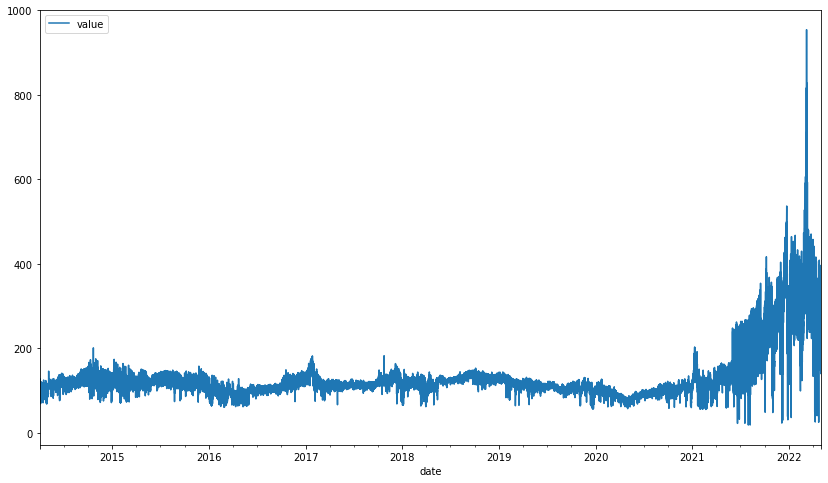

In [97]:
df_version_0.plot(figsize=(14,8))

In [98]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [99]:
size = int(len(df_version_0.dropna())*0.8)
size

56691

In [100]:
train = df_version_0.dropna().iloc[:size]
train.head()

,value
date,
2014-04-01 00:00:00,92.75
2014-04-01 01:00:00,86.46
2014-04-01 02:00:00,78.82
2014-04-01 03:00:00,77.47
2014-04-01 04:00:00,76.90


In [101]:
test = df_version_0.dropna().iloc[size:]
test.tail()

,value
date,
2022-05-01 19:00:00,218.24
2022-05-01 20:00:00,266.73
2022-05-01 21:00:00,282.01
2022-05-01 22:00:00,277.71
2022-05-01 23:00:00,264.99


In [106]:
fitted_model_add = ExponentialSmoothing(train['value'], trend='add', seasonal='add', seasonal_periods=24).fit()

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [107]:
test_predictions_hw_add=fitted_model_add.forecast(len(test))
test_predictions_hw_add

/home/berni/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


56691    109.251849
56692    107.723286
56693    106.684579
56694    108.295455
56695    109.525578
            ...    
70859    139.987234
70860    141.651646
70861    144.230821
70862    147.678109
70863    148.677345
Length: 14173, dtype: float64

In [108]:
test['value_hw'] = np.asarray(test_predictions_hw_add)
test

,value,value_hw
date,,
2020-09-18 09:00:00,110.45,109.251849
2020-09-18 10:00:00,106.15,107.723286
2020-09-18 11:00:00,104.93,106.684579
2020-09-18 12:00:00,103.69,108.295455
2020-09-18 13:00:00,101.70,109.525578
...,...,...
2022-05-01 19:00:00,218.24,139.987234
2022-05-01 20:00:00,266.73,141.651646
2022-05-01 21:00:00,282.01,144.230821


<AxesSubplot:xlabel='date'>

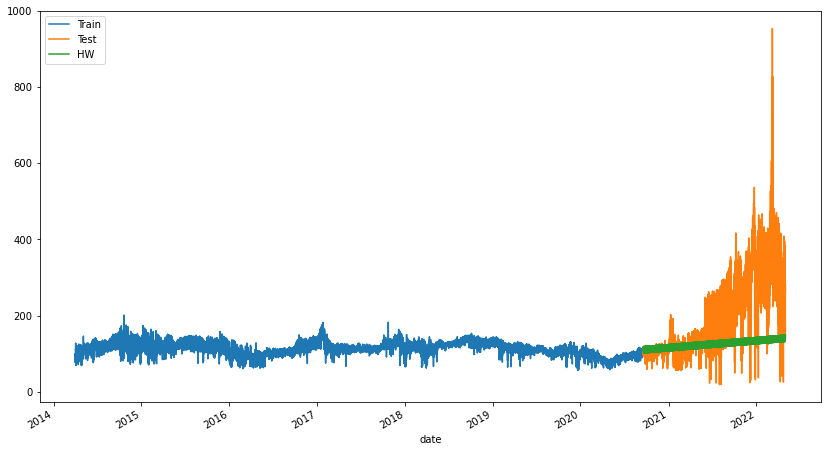

In [109]:
train['value'].plot(legend=True,label='Train', figsize=(14,8))
test['value'].plot(legend=True,label='Test', figsize=(14,8))
test['value_hw'].plot(legend=True,label='HW', figsize=(14,8))